In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import arviz as az
import scipy.stats as stats
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
y = 14
ntrials = 100

alpha_prior = 4
beta_prior = 6

with pm.Model() as bb_model:
    theta = pm.Beta("theta", alpha=alpha_prior, beta=beta_prior)
    obs = pm.Binomial("obs", p=theta, n=ntrials, observed=y)

In [4]:
with bb_model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:00.552602
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.438508
Transforming variables...
Transformation time =  0:00:00.015451


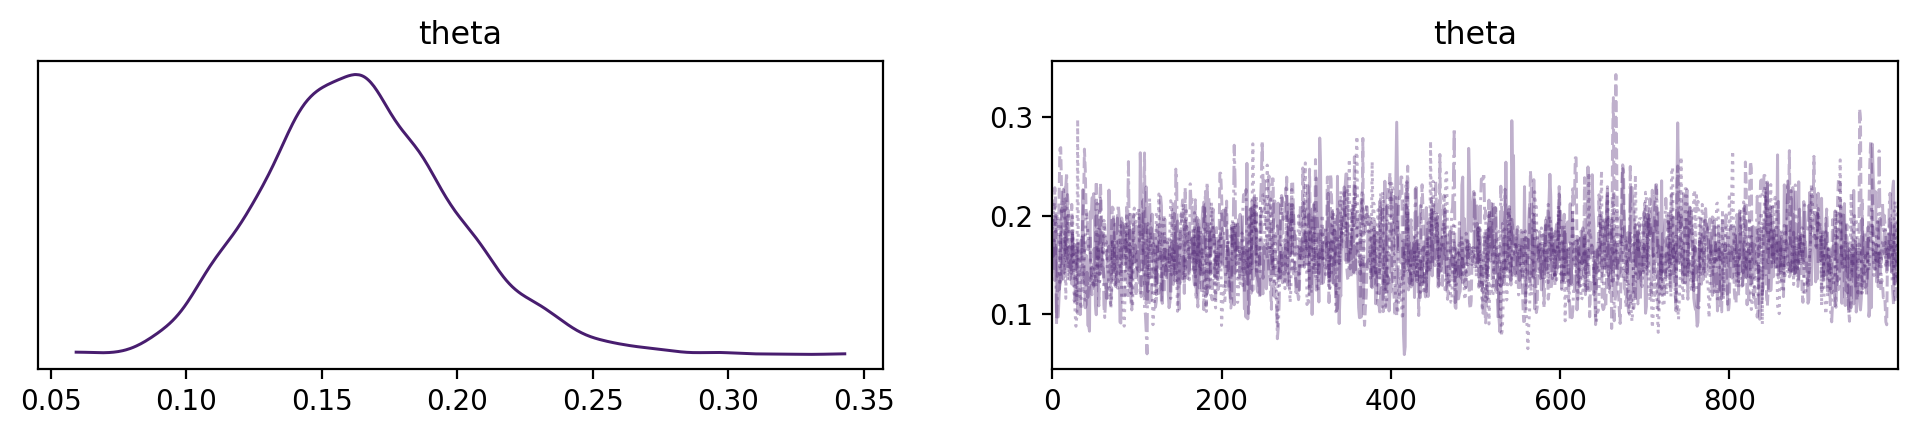

In [5]:
az.plot_trace(idata, combined=True)
plt.show()

In [6]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [7]:
idata.posterior["theta"]

<xarray.DataArray 'theta' (chain: 4, draw: 1000)>
array([[0.19500882, 0.17852443, 0.1463398 , ..., 0.14077348, 0.14077348,
        0.1346641 ],
       [0.1857456 , 0.1991514 , 0.20986606, ..., 0.20263801, 0.15322959,
        0.20334584],
       [0.15800173, 0.15915371, 0.15991143, ..., 0.11249542, 0.15650142,
        0.17952904],
       [0.16512169, 0.1504638 , 0.17530297, ..., 0.17178312, 0.1378523 ,
        0.19371812]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [8]:
idata.posterior["theta"].shape

(4, 1000)

In [9]:
idata.posterior["theta"][0, 1:10]

<xarray.DataArray 'theta' (draw: 9)>
array([0.17852443, 0.1463398 , 0.16753539, 0.19849499, 0.09727538,
       0.09727538, 0.09727538, 0.1167656 , 0.13266571])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 1 2 3 4 5 6 7 8 9

In [10]:
post = az.extract(idata)
post

<xarray.Dataset>
Dimensions:  (sample: 4000)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999
Data variables:
    theta    (sample) float64 0.195 0.1785 0.1463 ... 0.1718 0.1379 0.1937
Attributes:
    created_at:     2023-09-17T09:12:47.782049
    arviz_version:  0.16.0

In [11]:
post["theta"]

<xarray.DataArray 'theta' (sample: 4000)>
array([0.19500882, 0.17852443, 0.1463398 , ..., 0.17178312, 0.1378523 ,
       0.19371812])
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 7 ... 992 993 994 995 996 997 998 999

In [12]:
post["theta"].shape

(4000,)

In [13]:
post.mean()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 0.164

In [14]:
post["theta"].mean()

<xarray.DataArray 'theta' ()>
array(0.16396521)

In [15]:
post.median()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    theta    float64 0.1622

In [16]:
np.std(post["theta"])

<xarray.DataArray 'theta' ()>
array(0.03497285)

In [17]:
az.summary(idata, hdi_prob=0.94, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.164,0.035,0.101,0.229,0.001,0.001,1441.499,1919.125,1.002


In [18]:
ll = stats.beta.ppf(0.03, 18, 92)
ul = stats.beta.ppf(0.97, 18, 92)
list([ll, ul])

[0.10303527075398647, 0.23457657606771784]

In [19]:
print(np.mean(post["theta"] < 0.2))

<xarray.DataArray 'theta' ()>
array(0.852)


In [20]:
post_odds = (np.mean(post["theta"] < 0.2)) / (1 - np.mean(post["theta"] < 0.2))
print(post_odds)

<xarray.DataArray 'theta' ()>
array(5.75675676)


In [21]:
threshold = 0.2
prior_prob = stats.beta.cdf(threshold, a=alpha_prior, b=beta_prior)

In [22]:
prior_odds = prior_prob / (1 - prior_prob)
print(prior_odds)

0.09366320688790145


In [23]:
BF = post_odds / prior_odds
print(BF)

<xarray.DataArray 'theta' ()>
array(61.46230679)


In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

seaborn   : 0.12.2
pymc      : 5.6.1
scipy     : 1.10.1
arviz     : 0.16.0
numpy     : 1.25.2
pandas    : 2.0.3
matplotlib: 3.7.2

Watermark: 2.4.3

